### Kalman-HMM Filtering + EM-Algprithm 
---

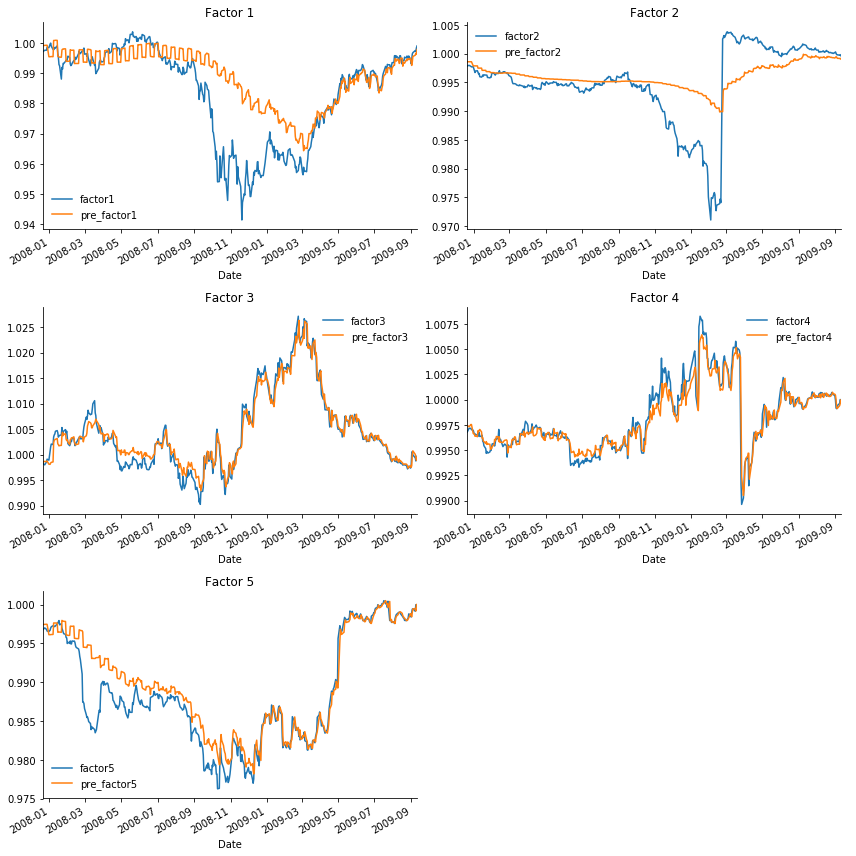

In [1]:
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import os 
from numpy.linalg import eig
%matplotlib inline


#1-state model prediction results 
state=1
factor=pd.read_excel('./output/rt_{}state/f.xlsx'.format(state))
pred=pd.read_excel('./output/rt_{}state/pf.xlsx'.format(state))
p=pd.read_excel('./output/rt_{}state/p.xlsx'.format(state))
factor['prob']=p[0]
for _ in pred.columns[1:]: 
    factor['pre_'+_]=pred[_]
factor.set_index('Date', inplace=True)


fig, axes=plt.subplots(nrows=3, ncols=2, figsize=(12,12))
factor[['factor1', 'pre_factor1']].plot(ax=axes[0,0], title='Factor 1')
for i, _ in  enumerate(pred.columns[2:]):
    factor[[_, 'pre_{}'.format(_)]].plot(ax=axes[(i+1)//2, (i+1)%2], title='Factor {}'.format(i+2))    
for i in range(len(pred.columns[1:])): 
    axes[i//2, i%2].spines['top'].set_visible(False) 
    axes[i//2, i%2].spines['right'].set_visible(False)
    axes[i//2, i%2].legend(frameon=False); 
axes[(i+1)//2, (i+1)%2].axis('off')
plt.tight_layout()
plt.savefig('./output/fig/pre_factor_1state')

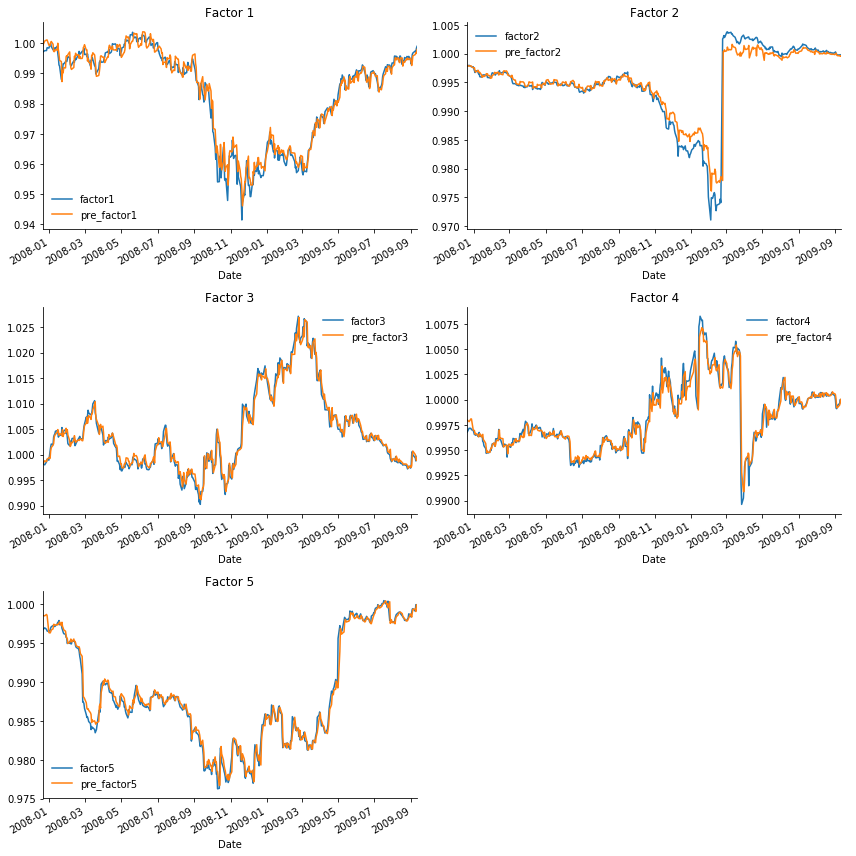

In [2]:
#2-state model prediction results 
state=2
factor=pd.read_excel('./output/rt_{}state/f.xlsx'.format(state))
pred=pd.read_excel('./output/rt_{}state/pf.xlsx'.format(state))
p=pd.read_excel('./output/rt_{}state/p.xlsx'.format(state))
factor['prob']=p[0]
for _ in pred.columns[1:]: 
    factor['pre_'+_]=pred[_]
factor.set_index('Date', inplace=True)


fig, axes=plt.subplots(nrows=3, ncols=2, figsize=(12,12))
factor[['factor1', 'pre_factor1']].plot(ax=axes[0,0], title='Factor 1')
for i, _ in  enumerate(pred.columns[2:]):
    factor[[_, 'pre_{}'.format(_)]].plot(ax=axes[(i+1)//2, (i+1)%2], title='Factor {}'.format(i+2))    
for i in range(len(pred.columns[1:])): 
    axes[i//2, i%2].spines['top'].set_visible(False) 
    axes[i//2, i%2].spines['right'].set_visible(False)
    axes[i//2, i%2].legend(frameon=False); 
axes[(i+1)//2, (i+1)%2].axis('off')
plt.tight_layout()
plt.savefig('./output/fig/pre_factor_2state')

#### Model Parameters 
---
* Probability 

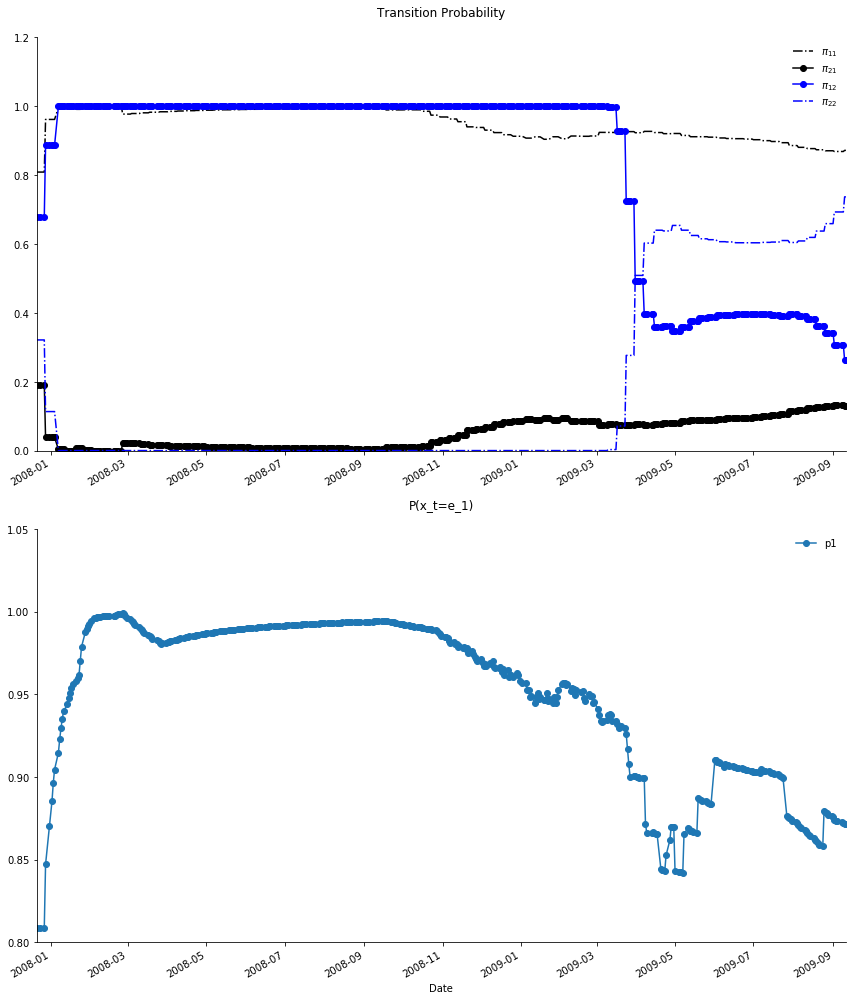

In [3]:
def roll_mean(v, window): 
    result=[]
    for i in range(len(v)): 
        if i<window: 
            result.append(np.mean(v[:i+1]))
        else: 
            result.append(np.mean(v[i-window+1: i+1]))
    return result
factor['p1']=roll_mean(factor['prob'].tolist(), 21)
mp=pd.read_excel('./output/rt_{}state/mp.xlsx'.format(state))
mp.set_index(mp.columns[0], inplace=True)
mp.index.name=None
mp.columns=['$\pi_{11}$','$\pi_{21}$','$\pi_{12}$','$\pi_{22}$']+mp.columns[4:].tolist()
 

fig, axes=plt.subplots(nrows=2, ncols=1, figsize=(12,14))
mp['$\pi_{11}$'].plot(ax=axes[0],color='k', style='-.',title='Transition Probability\n', ylim=[0,1.2])
mp['$\pi_{21}$'].plot(ax=axes[0],  marker='o', color='k')
mp['$\pi_{12}$'].plot(ax=axes[0], marker='o',color='b')
mp['$\pi_{22}$'].plot(ax=axes[0], color='b', style='-.')

factor['p1'].plot(ax=axes[1],  title='P(x_t=e_1)\n', marker='o', ylim=[0.8,1.05])   
for i in [0,1]: 
    axes[i].spines['top'].set_visible(False) 
    axes[i].spines['right'].set_visible(False)
    axes[i].legend(frameon=False, loc=1); 
plt.tight_layout()
plt.savefig('./output/fig/prob')

#### Model Parameters 
---
* Other Parameters 

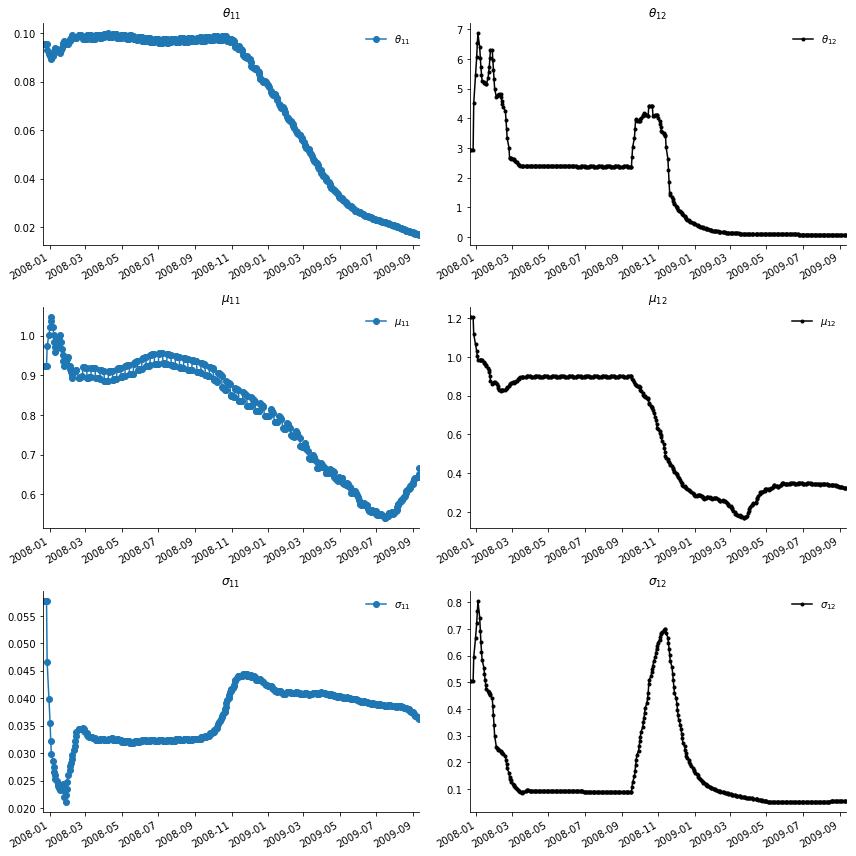

In [4]:
from math import log
import numpy as np 

#Two state Model parameters
mp['$\\theta_{11}$']=mp['kappa_s0_f1'].apply(lambda x: -1*log(x))
mp['$\\theta_{12}$']=mp['kappa_s1_f1'].apply(lambda x: -1*log(x))
mp['$\\theta_{11}$']=roll_mean(mp['$\\theta_{11}$'].tolist(), 21)
mp['$\\theta_{12}$']=roll_mean(mp['$\\theta_{12}$'].tolist(), 21)
mp['$\mu_{11}$']=mp['gamma_s0_f1']/(1-mp['kappa_s0_f1'])
mp['$\mu_{12}$']=mp['gamma_s1_f1']/(1-mp['kappa_s1_f1'])
mp['$\mu_{11}$']=roll_mean(mp['$\mu_{11}$'].tolist(), 21)
mp['$\mu_{12}$']=roll_mean(mp['$\mu_{12}$'].tolist(), 21)
mp['$\sigma_{11}$']=np.sqrt(mp['eta2_s0_f1']*2*mp['$\\theta_{11}$']/(1-mp['kappa_s0_f1']**2))
mp['$\sigma_{12}$']=np.sqrt(mp['eta2_s1_f1']*2*mp['$\\theta_{12}$']/(1-mp['kappa_s1_f1']**2)) 
mp['$\sigma_{11}$']=roll_mean(mp['$\sigma_{11}$'].tolist(), 21)
mp['$\sigma_{12}$']=roll_mean(mp['$\sigma_{12}$'].tolist(), 21) 

#====== 
fig, axes=plt.subplots(nrows=3, ncols=2, figsize=(12,12))
mp['$\\theta_{11}$'].plot(ax=axes[0,0], title='$\\theta_{11}$', marker='o')
mp['$\\theta_{12}$'].plot(ax=axes[0,1], title='$\\theta_{12}$', marker='.' , color='k')
mp['$\mu_{11}$'].plot(ax=axes[1,0], title='$\mu_{11}$', marker='o')
mp['$\mu_{12}$'].plot(ax=axes[1,1], title='$\mu_{12}$', marker='.', color='k')
mp['$\sigma_{11}$'].plot(ax=axes[2,0], title='$\sigma_{11}$', marker='o')
mp['$\sigma_{12}$'].plot(ax=axes[2,1], title='$\sigma_{12}$', marker='.', color='k')

    
for i in range(6): 
    axes[i//2, i%2].spines['top'].set_visible(False) 
    axes[i//2, i%2].spines['right'].set_visible(False)
    axes[i//2, i%2].legend(frameon=False); 
plt.tight_layout()
plt.savefig('./output/fig/mod_2state')

---

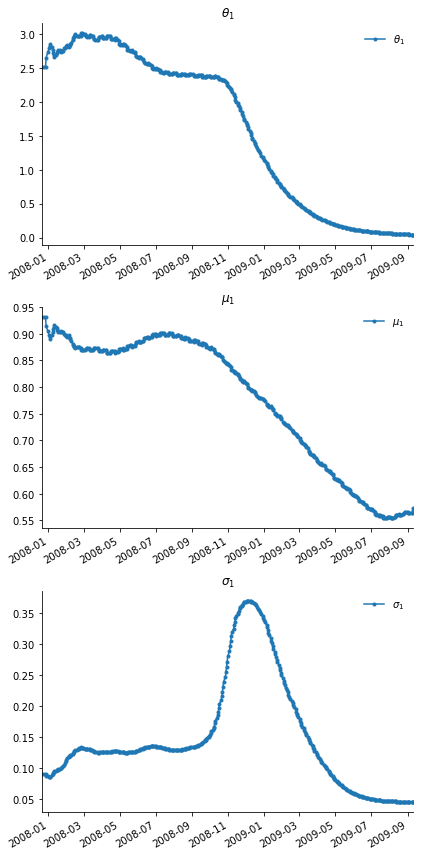

In [5]:
#One state Model parameters
mp1=pd.read_excel('./output/rt_1state/mp.xlsx')
mp1.set_index(mp1.columns[0], inplace=True)
mp1.index.name=None
 
    
mp1['$\\theta_{1}$']=mp1['kappa_s0_f1'].apply(lambda x: -1*log(x))
mp1['$\\theta_{1}$']=roll_mean(mp1['$\\theta_{1}$'].tolist(), 21) 
mp1['$\mu_{1}$']=mp1['gamma_s0_f1']/(1-mp1['kappa_s0_f1'])
mp1['$\mu_{1}$']=roll_mean(mp1['$\mu_{1}$'].tolist(), 21)
mp1['$\sigma_{1}$']=np.sqrt(mp1['eta2_s0_f1']*2*mp1['$\\theta_{1}$']/(1-mp1['kappa_s0_f1']**2))
mp1['$\sigma_{1}$']=roll_mean(mp1['$\sigma_{1}$'].tolist(), 21)
 

#== 
fig, axes=plt.subplots(nrows=3, ncols=1, figsize=(6,12))
mp1['$\\theta_{1}$'].plot(ax=axes[0], title='$\\theta_{1}$', marker='.')
mp1['$\mu_{1}$'].plot(ax=axes[1], title='$\mu_{1}$', marker='.')
mp1['$\sigma_{1}$'].plot(ax=axes[2], title='$\sigma_{1}$', marker='.')
 
for i in range(3): 
    axes[i].spines['top'].set_visible(False) 
    axes[i].spines['right'].set_visible(False)
    axes[i].legend(frameon=False); 
plt.tight_layout()
plt.savefig('./output/fig/mod_1state')

 
### Likelihood Functio 

---

In [6]:
ob=pd.read_excel('./output/rt_1state/f.xlsx'.format(state))
ob=ob.iloc[-132:]
ob.set_index('Date', inplace=True)
k=len(ob.columns) #number of key factors 
ob.head()

,factor1,factor2,factor3,factor4,factor5
Date,,,,,
2009-03-10,0.960088,1.003410,1.021307,1.003187,0.981293
2009-03-11,0.961638,1.003445,1.021977,1.003656,0.981226
2009-03-12,0.964445,1.003209,1.021214,1.004763,0.981545
2009-03-13,0.964440,1.003067,1.021720,1.005186,0.981912
2009-03-16,0.965626,1.002833,1.020319,1.005138,0.981830


In [7]:
def phi_k(t,  #time point 
          state, # number of states 
          s,  #current state
          args): #model parameters 
    from math import exp, sqrt, pi

    phi=1
    v1=ob.iloc[t].values
    v0=np.array([0.]*k) if t==0 else ob.iloc[t-1].values
    for i in range(k):
        phi*=(exp(-0.5*(v1[i]-args[i+s*k]*v0[i]-args[i+(s+state)*k])**2/args[i+(2*state+s)*k])/sqrt(2*pi*args[i+(2*state+s)*k]))
    return phi

def likelihood(state, args):
    '''
    args(e.g., state=2):
    =====
         p_ij: args[:4]=(pi_11, pi_12, pi_21, pi_22)
         kappa_i: args[4: 4+2*k]
         gamma_i: args[4+2*k:4+4*k]
         sigma_i^2: args[4+4*k:]
    '''
    from math import log
    
    if state==2:
        p=pd.read_excel('./output/rt_2state/p.xlsx')
        p=p.iloc[-132:]
        p.reset_index(inplace=True)
        p=p[p.columns[2:]]      
        pt=p.iloc[0]
        f_t=[]
        for i in range(state):
            f_t.append(pt[i]*phi_k(0,state, i, args.iloc[0].values[state**2:]))
        ft=sum(f_t)
        llh=log(ft+0.000001)
        for t in range(1, 132):
            f_t=[]
            pt=p.iloc[t]
            for i in range(state):
                for j in range(state):
                    temp=pt[i]*args.iloc[t].values[i*state+j]*phi_k(t, state,  j, args.iloc[t].values[state**2:])
                    f_t.append(temp)
            ft=sum(f_t)
            llh+=log(ft+0.000001)
        return llh
    else:
        ft=phi_k(0,state, 0, args.iloc[0].values[1:])
        llh=log(ft+0.000001)
        for t in range(1, 132):
            ft= phi_k(t, state,  0, args.iloc[t].values[1:])
            llh+=log(ft+0.000001)
        return llh


In [8]:
#two-state likelihood
args2=mp[mp.columns[:4+k*6]]
args2=args2.iloc[-132:]
llh2=likelihood(2, args2)
llh2

1565.4584214399313

In [9]:
#one-state likelihood
args1=mp1[mp1.columns[:16]].iloc[-132:]
llh1=likelihood(1, args1)
llh1

1156.5508127374883

---